# Import libraries and Constants

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sknn.mlp import Classifier, Layer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pickle
import numpy as np
import random
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots_adjust
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

EMOTION = {'ang': 0, 'hap' : 1, 'sad' : 2, 'neu' : 3, 'fru' : 4, 'exc': 5,
           'fea' : 6,'sur' : 7,'dis' : 8, 'oth' : 9, 'xxx':10}

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def parse_metric(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return {'FP': FP, 'FN': FN, 'TP':TP, 'TN':TN, 'TPR': TPR, 'TNR': TNR, 'PPV' : PPV, 'NPV' :NPV, 'FPR': FPR, 'FNR': FNR,
           'FDR': FDR, 'ACC':ACC}

class Input:
    
    def __init__(self, code=None, spectrogram=None, acoustic_features=None, transcript=None):
        self.__code = code
        self.__spectrogram = spectrogram
        self.__acoustic_features = acoustic_features
        self.__transcript = transcript
    
    def get_code(self):
        return self.__code
            
    def get_spectrogram(self):
        return self.__spectrogram
    
    def get_acoustic_features(self):
        return self.__acoustic_features
    
    def get_transcript(self):
        return self.__transcript
    
    def set_transcript(self, transcript):
        self.__transcript = transcript
    
    
class Output:
    def __init__(self, code, duration, annotated_categories, chosen_category, attributes):
        self.__code = code # file name
        self.__duration = duration #  duration [t1-t2]
        self.__annotated_categories= annotated_categories # array of different category evaluation of annotator
        self.__chosen_category = chosen_category  # final category which most of annotators choose
        self.__attributes = attributes # valance, arouse, dominance of emotion
        
    def get_code(self):
        return self.__code

    def get_duration(self):
        return self.__duration
    
    def get_annotated_categories(self):
        return self.__annotated_categories
    
    def get_chosen_category(self):
        return self.__chosen_category
    
    def get_attributes(self):
        return self.__attributes
                
    def get_consitency(self):
        """Get consitency of evaluation.
        """
        counts = np.unique(self.get_annotated_categories(), return_counts=True)[1]
        consitent_degree = np.max(counts)/np.sum(counts)
        return consitent_degree
            

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.1

# Load data (IEMOCAP-DATABASE)

In [2]:
file_handler_input = open('processed-data/input.obj', 'rb')
file_handler_output = open('processed-data/output.obj', 'rb')
input = np.array(pickle.load(file_handler_input))
output = np.array(pickle.load(file_handler_output))



print("Size input, output: {}, {}".format(len(input), len(output)))

Size input, output: 10039, 10039


- An input is an object including attributes such as **spectrogram, acoustic features, transcript**. Only **acoustic features** used in this  task.
- An output is an object including emotion labels(happy, neutral, excited...) and VAD (valance, arouse, dominance), number ranging from [1,5]. For example, VAD can be [4.5, 4, 3].

# 1. Analyze relationship between Valance, Arouse and Emotion

## 1.1 Valance and Emotions

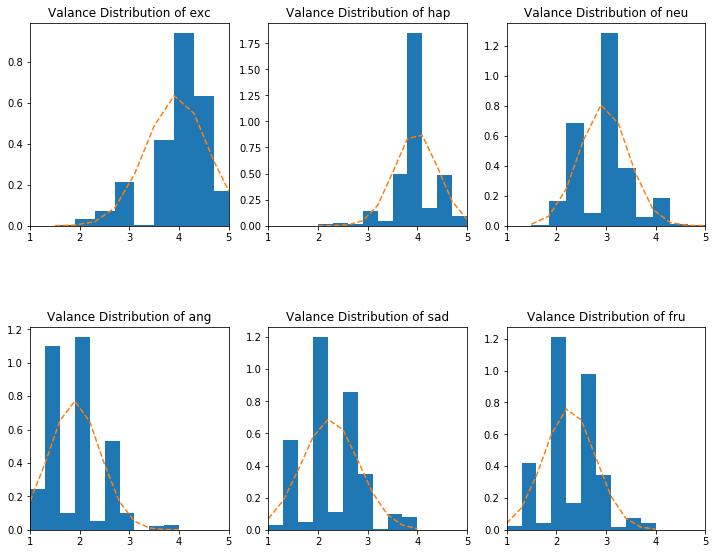

In [3]:
from itertools import groupby
from operator import itemgetter

category_valance = [(e.get_chosen_category(), e.get_attributes()[0]) for e in output if e.get_consitency() > 0.5]
LABELS = ['exc', 'hap', 'neu', 'ang', 'sad', 'fru']

groups = {}
for label in LABELS:
    groups[label] = [el[1] for el in category_valance if el[0] == label]

num_col = 3
fig, axs = plt.subplots(int(len(LABELS) / num_col), num_col,  figsize=(5,8))
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)

for i in range (0, len(LABELS)):
    row = int(i / num_col)
    col = i % num_col
    n, bins, patches = axs[row][col].hist(groups[LABELS[i]], density=1)
    axs[row][col].set_xlim([1,5])
    axs[row][col].set_title("Valance Distribution of {}".format(LABELS[i]))
    
    # add a 'best fit' line
    mu = np.mean(groups[LABELS[i]])
    sigma = np.std(groups[LABELS[i]])
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
    np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    axs[row][col].plot(bins, y, '--')

plt.show();

**Conclusion**: The value of valance can distinguish the pleasure of the emotion. Above figures illustrate that the (excited, hapiness, neu) can be in one group; (ang, sad and fru) can be in other group 

## 1.2  Arouse (Activation) and  emotions

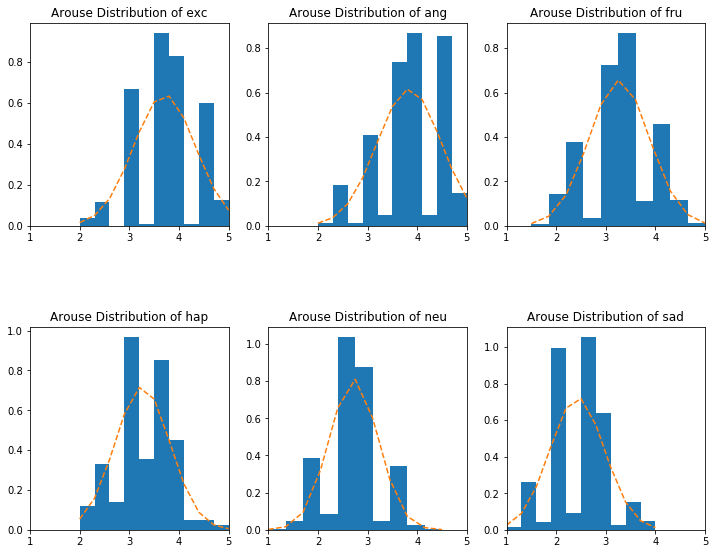

In [4]:
from itertools import groupby
from operator import itemgetter



category_arouse = [(e.get_chosen_category(), e.get_attributes()[1]) for e in output if e.get_consitency()>0.7]
# groups = [(k, list(list(zip(*category_arouse[0:5000]))[1])) for k, g in groupby(a, itemgetter(0))]
LABELS = ['exc', 'ang', 'fru', 'hap', 'neu', 'sad']

groups = {}
for label in LABELS:
    groups[label] = [el[1] for el in category_arouse if el[0] == label]

#print(groups)
num_col = 3
fig, axs = plt.subplots(int(len(LABELS) / num_col), num_col,  figsize=(5,8))
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)

for i in range (0, len(LABELS)):
    row = int(i / num_col)
    col = i % num_col
    n, bins, patches = axs[row][col].hist(groups[LABELS[i]], density = 1)
    axs[row][col].set_xlim([1,5])
    axs[row][col].set_title("Arouse Distribution of {}".format(LABELS[i]))
    
      # add a 'best fit' line
    mu = np.mean(groups[LABELS[i]])
    sigma = np.std(groups[LABELS[i]])
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
    np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    axs[row][col].plot(bins, y, '--')
    
plt.show();



**Conclusion:** The arouse can distinguish quite well the activation of emotion. Above figures indicate that the group of (excited, angry, frustrated, happy) have higher arouse value than the group of (neutral and sadness)

# 2. Training model and evaluating model in IEMOCAP-DATABASE

## 2.1 Filter data

I will choose the emotions that are **popular** in the interview situation **(excited, happy, sad, neutral)**.  The frustrated and anger seems do not exist in interview environment, so I remove them 

In [5]:
LABELS = [ 'exc' ,'hap', 'sad', 'neu']
in_out = list(filter(lambda x: ~np.isnan(np.array(x[0].get_acoustic_features(),  dtype=np.float64)).any() and x[1].get_chosen_category() in LABELS , zip(input, output)))
input, output = zip(*in_out)

print("Size input, output after filtering: {}, {}".format(len(input), len(output)))

Size input, output after filtering: 4411, 4411


## 2.2 Preprocess data

In [6]:

# Get acoustic features and normalize it.
X = np.array([i.get_acoustic_features() for i in input])
X_norm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))


# Get best features
num_features = 88
selection_ranking = np.array([0, 66, 11, 73, 4, 0, 7, 47, 8, 24, 0, 23, 27, 28, 40, 41, 
 6, 78, 30, 77, 16, 84, 10, 67, 3, 54, 76, 68, 56, 65, 31, 9, 55, 81, 21, 61, 38, 
 14, 17, 39, 51, 70, 62, 79, 43, 44, 57, 22, 69, 53, 34, 83, 35, 15, 80, 42, 18, 72,
 12, 60, 25, 52, 0, 58, 59, 64, 75, 74, 6, 33, 20, 45, 5, 29, 49, 48, 13, 32, 82, 19, 63, 36, 
 0, 2, 46, 37, 50, 71])

X_norm = np.array(list(map(lambda x: x[selection_ranking <= num_features], X_norm)))
print(X_norm.shape)

#Save max and min values of X for Cross-database testting
max_acoustic_features = np.max(X, axis=0)
min_acoustic_features = np.min(X, axis=0)

# Get valance and arouse
y_valance = np.array([i.get_attributes()[0] for i in output]) 
y_arouse =  np.array([i.get_attributes()[1] for i in output]) 

(4411, 88)


## 2.3 Scatter plot arouse, valance  

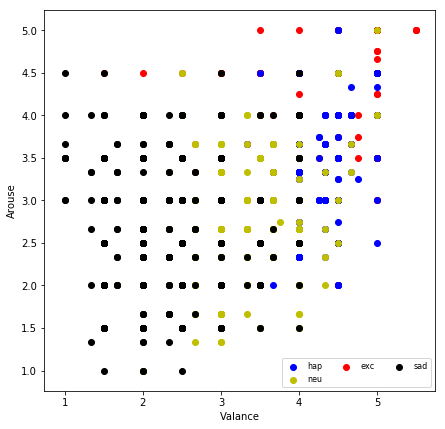

In [7]:
LABELS = ['exc', 'hap', 'neu', 'sad']
COLORS = {'exc': 'r', 'hap': 'b', 'neu' : 'y', 'sad': 'black'}
valance_groups = {}
arouse_groups = {}
scatter_groups = {}
plt.figure(figsize=(7,7))
for l in LABELS:
    valance_groups[l] = np.array([i.get_attributes()[0] for i in output if i.get_chosen_category() == l])
    arouse_groups[l] = np.array([i.get_attributes()[1] for i in output if i.get_chosen_category() == l])
    scatter_groups[l] = plt.scatter(valance_groups[l], arouse_groups[l], color= COLORS[l])

plt.xlabel("Valance")
plt.ylabel("Arouse")
plt.legend(tuple(scatter_groups.values()),
           tuple(scatter_groups.keys()),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=8)


## 2.4 Split data

In [8]:
#Spit data
X_train, X_test, y_train, y_test = train_test_split(X_norm, output, test_size=0.2, random_state=300)
print("Size training, testing set: ", len(X_train), ", ", len(X_test))

y_train_label = np.array([i.get_chosen_category() for i in y_train])
y_test_label = np.array([i.get_chosen_category() for i in y_test])

y_train_valance = np.array([i.get_attributes()[0] for i in y_train]) 
y_test_valance =  np.array([i.get_attributes()[0] for i in y_test]) 
y_train_arouse = np.array([i.get_attributes()[1] for i in y_train]) 
y_test_arouse =  np.array([i.get_attributes()[1] for i in y_test]) 


Size training, testing set:  3528 ,  883


## 2.5 Evaluate Valance

- I will  use the SVM regression model for training.
- Then I will  evaluate the learned regression models for a two-class classification task.
Based on the idea on this paper https://arxiv.org/pdf/1504.03425.pdf (Section 5.2.1)

### 2.5.1 Training using SVM regression model

Correlation Coefficient: 0.575005959104334
MSE: 0.4950702053517122, MAE: 0.5594608810319374, MAD: 0.4685914082852696, MAPE: 20.306561440246153 %


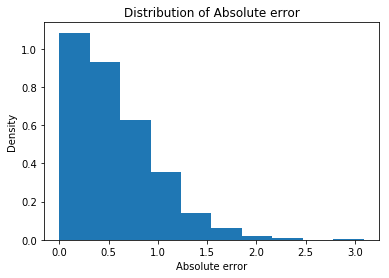

In [9]:
# Training, predicts
clf = LogisticRegression()
clf = svm.SVR(kernel='linear')
clf.fit(X_train, y_train_valance)

# Save model into file
file_handler = open("model/model_regression_valance.sav", 'wb')
pickle.dump(clf, file_handler)


predicts_valance = clf.predict(X_test)

# Caculates Coefficient and error metrics
print("Correlation Coefficient:", np.sqrt(r2_score(y_test_valance, predicts_valance)))
print("MSE: {}, MAE: {}, MAD: {}, MAPE: {} %".format(mean_squared_error(y_test_valance, predicts_valance),
                                                   mean_absolute_error(y_test_valance, predicts_valance),
                                                   median_absolute_error(y_test_valance, predicts_valance),
                                                   mean_absolute_percentage_error(y_test_valance, predicts_valance)
                                                  ))

# Draw ditribution of absolute error
plt.hist(np.abs(predicts_valance - y_test_valance), density = 1)
plt.title("Distribution of Absolute error")
plt.xlabel("Absolute error")
plt.ylabel("Density");


**Conclusion:** With the range of value from [1-5], I think the MSE < 0.6 could be acceptable.

#### Distribution of prediction

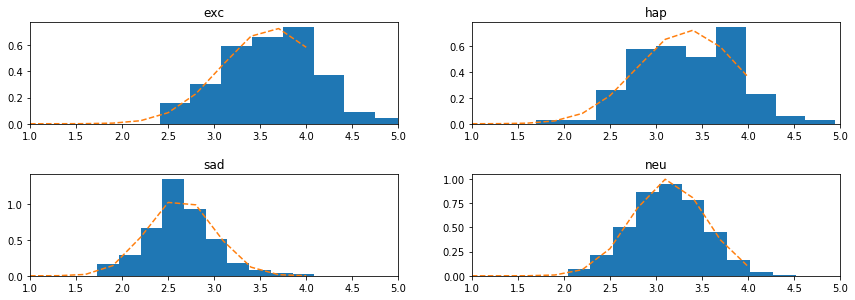

In [10]:
LABELS = ['exc', 'hap', 'sad', 'neu']
groups = {}
for l in LABELS:
    groups[l] =  np.array([predicts_valance[i] for i in range (0, len(predicts_valance)) if y_test_label[i] == l])

fig, axs = plt.subplots(2,2)
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)
for i in range(0,4):
    row = int(i/2)
    col = int(i%2)
    axs[row][col].hist(np.array(groups[LABELS[i]]), density=1)
    axs[row][col].set_xlim([1,5])
    axs[row][col].set_title(LABELS[i])
    mu = np.mean(groups[LABELS[i]])
    sigma = np.std(groups[LABELS[i]])
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    axs[row][col].plot(bins, y, '--')

plt.show()
    

### 2.5.2 Evaluation the learned regression model for two-class classification task

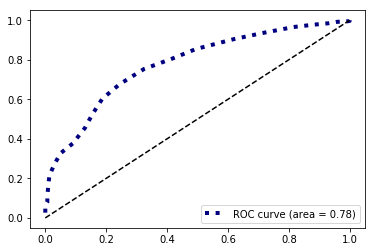

In [11]:
# Using the median value as a split point.
split_point = np.median(y_train_valance)

# Categorize the values. All the values smaller than "split_point" is consider as low-valance and vice-versa
y_test_binary = np.array([int(i >= split_point) for i in y_test_valance])

# According to the predicting values,
# Using thresholds ranging from [1-5] to indicate the True Posivite Rate and False Positive Rate
# Then draw the ROC-curve
thresholds = np.linspace(0, 5, 50)
tpr_arr = []
fpr_arr = []
thresh_arr = [] 
for t in thresholds:
    predict_binary = np.array([int(i >= t) for i in predicts_valance])
    cfm = confusion_matrix(y_test_binary, predict_binary)
    parse_values = parse_metric(cfm)
    tpr_arr.append(parse_values['TPR'])
    fpr_arr.append(parse_values['FPR'])
    thresh_arr.append(t)

fpr_arr = np.asarray(fpr_arr)
tpr_arr = np.asarray(tpr_arr)
roc_auc = auc(fpr_arr[:,1], tpr_arr[:,1])
plt.plot(fpr_arr[:,1], tpr_arr[:,1], label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.show();




**Conclusion**:  I think that the ROC value (>0.7) is acceptable with psychology-related task.
According to this discussion https://www.researchgate.net/post/What_is_the_value_of_the_area_under_the_roc_curve_AUC_to_conclude_that_a_classifier_is_excellent 


## 2.6 Evaluate Arouse(Activation)

### 2.6.1 Training using SVM regression model

Correlation Coefficient: 0.6453917510176309
MSE: 0.2987086259580722, MAE: 0.4393402122182132, MAD: 0.3802368543943557, MAPE: 15.980343358024959 %


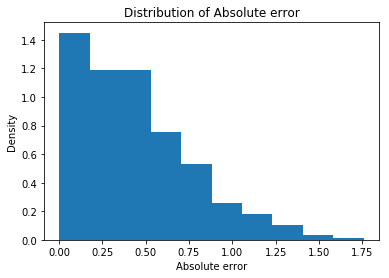

In [12]:
# Training, predicts
clf = LogisticRegression()
clf = svm.SVR(kernel='linear')
clf.fit(X_train, y_train_arouse)
predicts_arouse = clf.predict(X_test)

# Save model into file
file_handler = open("model/model_regression_arouse.sav", 'wb')
pickle.dump(clf, file_handler)

# Caculates Coefficient and error metrics
print("Correlation Coefficient:", np.sqrt(r2_score(y_test_arouse, predicts_arouse)))
print("MSE: {}, MAE: {}, MAD: {}, MAPE: {} %".format(mean_squared_error(y_test_arouse, predicts_arouse),
                                                   mean_absolute_error(y_test_arouse, predicts_arouse),
                                                   median_absolute_error(y_test_arouse, predicts_arouse),
                                                   mean_absolute_percentage_error(y_test_arouse, predicts_arouse)
                                                  ))

# Draw ditribution of absolute error
plt.hist(np.abs(predicts_arouse - y_test_arouse), density = 1.0)
plt.title("Distribution of Absolute error")
plt.xlabel("Absolute error")
plt.ylabel("Density");


**Conclusion:**  
- With the range of value from [1-5], I think the MSE < **0.5** could be very good.  
- The model for arouse is better than that of valance. 

#### Distribution of arouse prediction

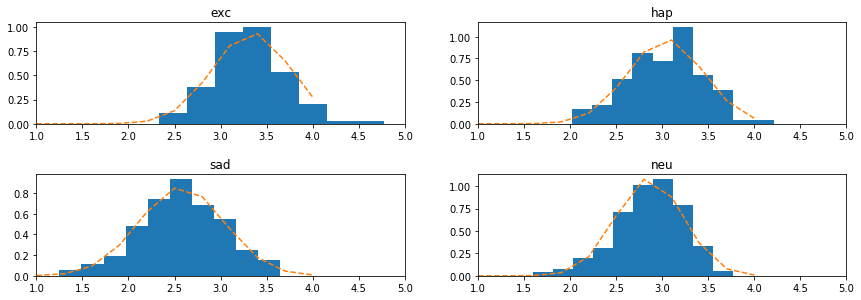

In [13]:
LABELS = ['exc', 'hap', 'sad', 'neu']
groups = {}
for l in LABELS:
    groups[l] =  np.array([predicts_arouse[i] for i in range (0, len(predicts_arouse)) if y_test_label[i] == l])

fig, axs = plt.subplots(2,2)
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)
for i in range(0,4):
    row = int(i/2)
    col = int(i%2)
    axs[row][col].hist(np.array(groups[LABELS[i]]), density=1)
    axs[row][col].set_xlim([1,5])
    axs[row][col].set_title(LABELS[i])
    mu = np.mean(groups[LABELS[i]])
    sigma = np.std(groups[LABELS[i]])
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    axs[row][col].plot(bins, y, '--')

plt.show()

### 2.6.2 Evaluation the learned regression model for two-class classification task

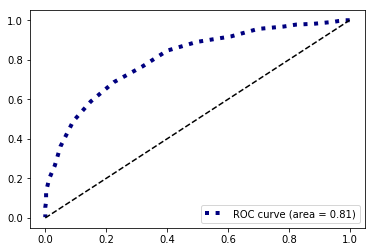

In [14]:
# Using the median value as a split point.
split_point = np.median(y_train_arouse)

# Categorize the values. All the values smaller than "split_point" is consider as low-arouse and vice-versa
y_test_binary = np.array([int(i >= split_point) for i in y_test_arouse])

# According to the predicting values,
# Using thresholds ranging from [1-5] to indicate the True Posivite Rate and False Positive Rate
# Then draw the ROC-curve
thresholds = np.linspace(0, 5, 50)
tpr_arr = []
fpr_arr = []
thresh_arr = [] 
for t in thresholds:
    predict_binary = np.array([int(i >= t) for i in predicts_arouse])
    cfm = confusion_matrix(y_test_binary, predict_binary)
    parse_values = parse_metric(cfm)
    tpr_arr.append(parse_values['TPR'])
    fpr_arr.append(parse_values['FPR'])
    thresh_arr.append(t)

fpr_arr = np.asarray(fpr_arr)
tpr_arr = np.asarray(tpr_arr)
roc_auc = auc(fpr_arr[:,1], tpr_arr[:,1])
plt.plot(fpr_arr[:,1], tpr_arr[:,1], label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.show();




**Conclusion**: The ROC value of model predicting arouse is better than that of valance

## 2.7 Scatter plot of valance, arouse prediction

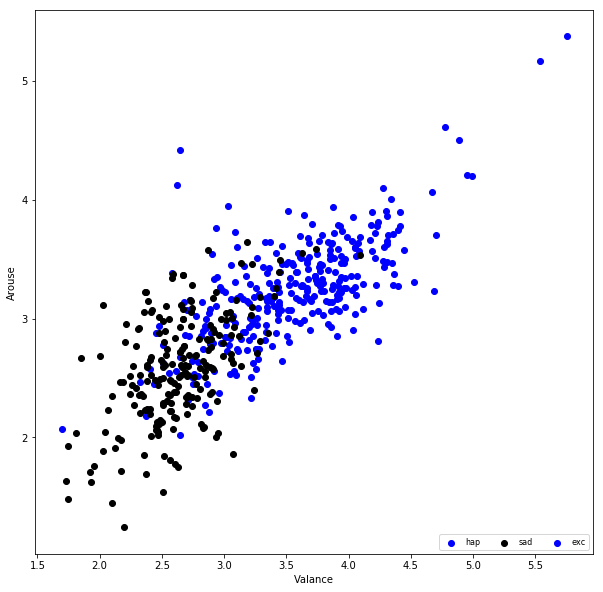

In [15]:
LABELS = ['exc', 'hap', 'sad']
COLORS = {'exc': 'b', 'hap': 'b', 'sad': 'black'}
valance_groups = {}
arouse_groups = {}
scatter_groups = {}
plt.figure(figsize=(10,10))
for l in LABELS:
    valance_groups[l] = np.array([predicts_valance[i] for i in range (0, len(y_test)) if y_test[i].get_chosen_category() == l])
    arouse_groups[l] = np.array([predicts_arouse[i] for i in range(0, len(y_test)) if y_test[i].get_chosen_category() == l])
    scatter_groups[l] = plt.scatter(valance_groups[l], arouse_groups[l], color= COLORS[l])

plt.xlabel("Valance")
plt.ylabel("Arouse")
plt.legend(tuple(scatter_groups.values()),
           tuple(scatter_groups.keys()),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=8)


 ## 3. Cross-Database Evaluation

**Load data in different data set: EMO-DATA**

In [16]:
file_handler_input = open('processed-data/input-EMO.obj', 'rb')
file_handler_output = open('processed-data/output-EMO.obj', 'rb')
input_EMO = np.array(pickle.load(file_handler_input))
output_EMO = np.array(pickle.load(file_handler_output))
print("Size input, output: {}, {}".format(len(input), len(output)))

Size input, output: 4411, 4411


**Load trained model **

In [17]:
model_regression_valance = pickle.load(open("model/model_regression_valance.sav", 'rb'))
model_regression_arouse = pickle.load(open("model/model_regression_arouse.sav", 'rb'))

**Predict valance**

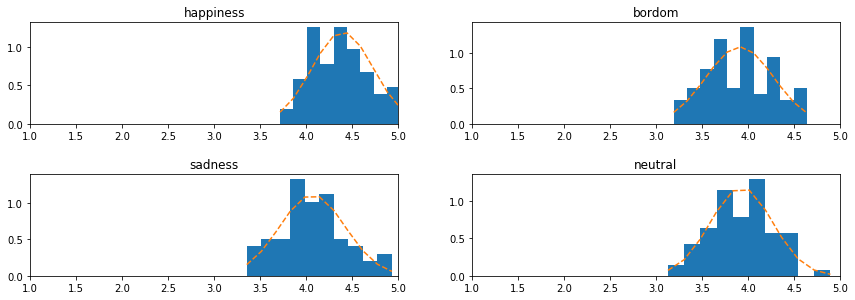

In [18]:
LABELS = ['F', 'L', 'T', 'N']
EMOTION = {'L': 'bordom', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}

    
fig , axs = plt.subplots(2, 2)
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)
for i in range(0, len(LABELS)):
    in_out = filter(lambda x: x[1] == LABELS[i] , zip(input_EMO, output_EMO))
    X, y = zip(*in_out)
    X = np.array(X)
    #X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))
    X = (X - min_acoustic_features) / (max_acoustic_features - min_acoustic_features)
   # X = (X - np.mean(X)) / np.std(X)

    # Get best features
    #num_features = 10
    

    X = np.array(list(map(lambda x: x[selection_ranking <= num_features], X)))
    predicts_valance_EMO = model_regression_valance.predict(X)
    
    row = int(i/2)
    col = int(i%2)
    n, bins, patches = axs[row][col].hist(predicts_valance_EMO, density=1)
    axs[row][col].set_xlim([1,5])
    axs[row][col].set_title(EMOTION[LABELS[i]])
    
    mu = np.mean(predicts_valance_EMO)
    sigma = np.std(predicts_valance_EMO)
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    axs[row][col].plot(bins, y, '--')

plt.show()


    

**Conclusion**: The happiness have higher valance value than (bordom, sadness, neutral)

**Predict arouse**

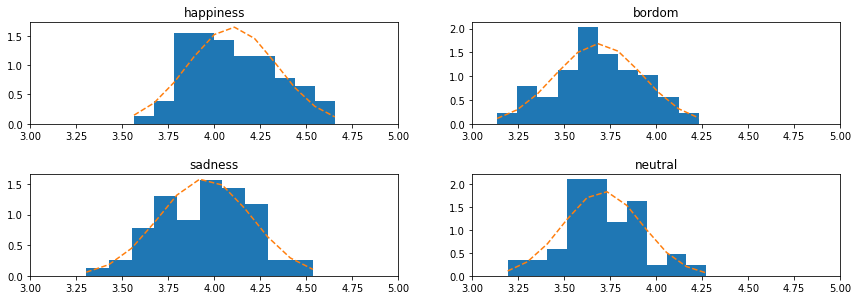

In [19]:
LABELS = ['F', 'L', 'T', 'N']
EMOTION = {'L': 'bordom', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}

    
fig , axs = plt.subplots(2, 2)
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)
for i in range(0, len(LABELS)):
    in_out = filter(lambda x: x[1] == LABELS[i] , zip(input_EMO, output_EMO))
    X, y = zip(*in_out)
    X = np.array(X)
   # X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))
    X = (X - min_acoustic_features) / (max_acoustic_features - min_acoustic_features)
    
    # Get best features
    #num_features = 10
   
    X = np.array(list(map(lambda x: x[selection_ranking <= num_features], X)))
    predicts_arouse_EMO = model_regression_arouse.predict(X)
#     n, bins, patches = axs[i].hist(predicts, density=1)
        
#     axs[i].set_xlim([1,5])
#     axs[i].set_title("Arouse Distribution of {}".format(EMOTION[LABELS[i]]))
    row = int(i/2)
    col = int(i%2)
    n, bins, patches = axs[row][col].hist(predicts_arouse_EMO, density=1)
    axs[row][col].set_xlim([3,5])
    axs[row][col].set_title(EMOTION[LABELS[i]])
    
    mu = np.mean(predicts_arouse_EMO)
    sigma = np.std(predicts_arouse_EMO)
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    axs[row][col].plot(bins, y, '--')
    


**Conclusion**: It seems like there is no difference between arouse values of happiness and (bordom, sadness, neutral) ???

**Scatter plot valance and arouse of prediction**

(535, 88)
size1: 535, size2: 535


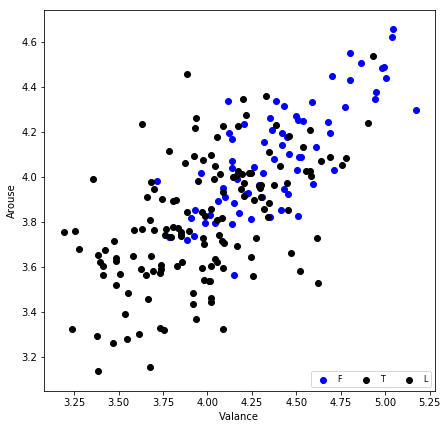

In [20]:
LABELS = ['F', 'L', 'T']
#EMOTION = {'L': 'bordom', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}
COLORS = {'F': 'b', 'L': 'black', 'T': 'black'}

normalized_input_EMO = (input_EMO - min_acoustic_features) / (max_acoustic_features - min_acoustic_features)

# Get best features
#num_features = 10


normalized_input_EMO = np.array(list(map(lambda x: x[selection_ranking <= num_features], normalized_input_EMO)))
print(normalized_input_EMO.shape)
predicts_valance_EMO = model_regression_valance.predict(normalized_input_EMO)
predicts_arouse_EMO = model_regression_arouse.predict(normalized_input_EMO)


valance_groups = {}
arouse_groups = {}
scatter_groups = {}
plt.figure(figsize=(7,7))
print("size1: {}, size2: {}".format(len(predicts_valance_EMO), len(output_EMO)))
for l in LABELS:
    valance_groups[l] = np.array([predicts_valance_EMO[i] for i in range (0, len(output_EMO)) if output_EMO[i] == l])
    arouse_groups[l] = np.array([predicts_arouse_EMO[i] for i in range(0, len(output_EMO)) if output_EMO[i] == l])
    scatter_groups[l] = plt.scatter(valance_groups[l], arouse_groups[l], color= COLORS[l])

plt.xlabel("Valance")
plt.ylabel("Arouse")
plt.legend(tuple(scatter_groups.values()),
           tuple(scatter_groups.keys()),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=8)


## Conclusion for regression method with  valance, arouse 
** In each kind of database, the value of valance and arouse to distinguish the positive and negative emotion is very different. Therefore it is not reasonable to use valance and arouse to estimate the positive in practice**

# 4. Use classfication method

In [3]:
file_handler_input = open('processed-data/input.obj', 'rb')
file_handler_output = open('processed-data/output.obj', 'rb')
input = np.array(pickle.load(file_handler_input))
output = np.array(pickle.load(file_handler_output))


in_out = list(filter(lambda x: ~np.isnan(np.array(x[0].get_acoustic_features(),  dtype=np.float64)).any()  , zip(input, output)))
input, output = zip(*in_out)
X = np.array([i.get_acoustic_features() for i in input])
max_acoustic_features = np.max(X, axis=0)
min_acoustic_features = np.min(X,  axis=0)
mean_acoustic_features = np.mean(X, axis = 0)
std_acoustic_features = np.std(X, axis = 0)

##Dump max, min, mean, std of acoustic features into files
pickle.dump(max_acoustic_features, open('processed-data/max_acoustic_features.obj', 'wb'))
pickle.dump(min_acoustic_features, open('processed-data/min_acoustic_features.obj', 'wb'))
pickle.dump(mean_acoustic_features, open('processed-data/mean_acoustic_features.obj', 'wb'))
pickle.dump(std_acoustic_features, open('processed-data/std_acoustic_features.obj', 'wb'))


print("Size input, output: {}, {}".format(len(input), len(output)))


Size input, output: 10009, 10009


## 4.1 Filter data

In [4]:
LABELS = [ 'exc' ,'hap', 'sad']
in_out = list(filter(lambda x: ~np.isnan(np.array(x[0].get_acoustic_features(),  dtype=np.float64)).any() and x[1].get_chosen_category() in LABELS , zip(input, output)))
input, output = zip(*in_out)

print("Size input, output after filtering: {}, {}".format(len(input), len(output)))

Size input, output after filtering: 2709, 2709


In [9]:
durations = np.array([e.get_duration()  for e in output])
dentas = durations[:,1]- durations[:,0]
print("min: {}, max:  {}, mean: {}, median: {}, std: {}".format(np.min(dentas),np.max(dentas), np.mean(dentas)
                                                               ,np.median(dentas), np.std(dentas)))

min: 0.5849999999999973, max:  34.1388, mean: 4.975421779254337, median: 3.859999999999985, std: 3.59290931539892


## 4.2 Preprocess

In [75]:




# Get acoustic features and normalize it.
X = np.array([i.get_acoustic_features() for i in input])
#print(X[0:2])
#X_norm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))
#X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
#X_norm = (X - mean_acoustic_features) / std_acoustic_features
X_norm = (X - min_acoustic_features)/ (max_acoustic_features - min_acoustic_features)
# Get best features
#X_norm = np.array(list(map(lambda x: x[selection_ranking <= num_features], X_norm)))
X_norm = X_norm[:,1:]
print(len(X_norm[0]))


#Save max and min values of X for Cross-database testting
# max_acoustic_features = np.max(X, axis=0)
# min_acoustic_features = np.min(X,  axis=0)
# mean_acoustic_features = np.mean(X, axis = 0)
# std_acoustic_features = np.std(X, axis = 0)

#Categorize ouput
LABELS_INT = {'exc':1, 'hap' :1, 'sad': 0}
output_labels = np.array([int(LABELS_INT[i.get_chosen_category()]) for i in output ])



87


## 4.3 Split data

In [76]:
#Spit data
X_train, X_test, y_train, y_test = train_test_split(X_norm, output_labels, test_size=0.2, random_state=300)
print("Size training, testing set: ", len(X_train), ", ", len(X_test))

Size training, testing set:  2167 ,  542


## 4.4 Training and testing on IEMOCAP data

In [77]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
# Training, predicts
#clf = LogisticRegression()
#clf = svm.SVR(kernel='linear')
#clf = GaussianProcessClassifier(1.0 * RBF(1.0))
#clf = LogisticRegression()
#clf =  RandomForestClassifier(max_depth=3, n_estimators=100, max_features=2)
clf = MLPClassifier(hidden_layer_sizes= (100,), learning_rate_init= 0.001)
# from keras.utils.np_utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Activation
# from keras import backend as K
# import tensorflow as tf
# from keras.utils.np_utils import to_categorical

# y_train_one_hot = np.array([to_categorical(y,2)  for y in y_train])

# y_test_one_hot = np.array([to_categorical(y,2)  for y in y_test])
# clf = Sequential([
#         Dense(64, input_shape=(15,), kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(32, kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(16,kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(8, kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(2),
#         Activation('sigmoid'),
#     ])
# clf.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
# clf.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), epochs = 10)



clf.fit(X_train, y_train)
# Save model into file
file_handler = open("model/model_classification.sav", 'wb')
pickle.dump(clf, file_handler)


# predicts = clf.predict(X_test)
# pre_pro = clf.predict_proba(X_test)
# print("confusion matrix: \n", confusion_matrix(y_test, predicts))
# parse_matrix = parse_metric(confusion_matrix(y_test, predicts))
# print("Presison: {}\nRecall: {}\nAcc: {}".format(parse_matrix['PPV'], parse_matrix['TPR'], parse_matrix['ACC'][0]))

### ROC

In [26]:
# fpr, tpr, thresholds  = roc_curve(y_test, pre_pro[:, 1], pos_label=1)
# roc_auc = auc(fpr, tpr)

# plt.plot(fpr, tpr, color='darkorange',
#           lw=0.9,label='ROC curve (area = %0.2f)' % roc_auc)

# plt.plot([0, 1], [0, 1], 'k--')
# plt.legend(loc="lower right")

## 4.5 Testing on EMO-DATABASE

### 4.5.1 Load data

In [54]:
file_handler_input = open('processed-data/input-EMO.obj', 'rb')
file_handler_output = open('processed-data/output-EMO.obj', 'rb')
input_EMO = np.array(pickle.load(file_handler_input))
output_EMO = np.array(pickle.load(file_handler_output))
print("Size input, output: {}, {}".format(len(input_EMO), len(input_EMO)))


Size input, output: 535, 535


### 4.5.2 Filter data

In [55]:
LABELS = ['F', 'T', 'L']
EMOTION = {'L': 'bordom', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}
in_out_EMO  = filter(lambda x: x[1] in LABELS , zip(input_EMO, output_EMO))
input_EMO_filtered, output_EMO_filtered = zip(*in_out_EMO)

print("Size after filtering input: {}, output: {}".format(len(input_EMO_filtered), len(output_EMO_filtered)))

Size after filtering input: 214, output: 214


### 4.5.2 Preprocess data

In [65]:
# Normalize and select features
#print(input_EMO_filtered)
#input_EMO_normalized = (input_EMO_filtered - np.min(input_EMO_filtered)) / (np.max(input_EMO_filtered) - np.min(input_EMO_filtered))
#rint(input_EMO_filtered.shape)
input_EMO_normalized = np.abs((np.array(input_EMO_filtered)[:,1:] - min_acoustic_features[1:]) / (max_acoustic_features[1:] - min_acoustic_features[1:]))
#input_EMO_normalized = (input_EMO_filtered - mean_acoustic_features) / std_acoustic_features
#input_EMO_normalized = np.array(list(map(lambda x: x[selection_ranking <= num_features], input_EMO_normalized)))

#Categorize output
LABELS_INT =  { 'F': 1, 'T': 0, 'L':0}
output_int = np.array(list(map(lambda x: int(LABELS_INT[x]), output_EMO_filtered)))
print(np.sum(output_int))
print("Finish preprocessing")

71
Finish preprocessing


### 4.5.3 Load classification model trained in IEMOCAP

In [66]:
#model_classification = pickle.load(open("model/model_classification.sav", 'rb'))
model_classification = clf

### 4.5.4 Testing

In [68]:
pre = model_classification.predict(input_EMO_normalized)
pre_pro = model_classification.predict_proba(input_EMO_normalized)
#pre_int  = np.argmax(pre)
print(pre)
#print(output_int)
print(np.argmax(pre, axis = 1))
print("confusion matrix: \n", confusion_matrix(output_int, np.argmax(pre)))
parse_matrix = parse_metric(confusion_matrix(output_int, pre_int))
print("Presison: {}\nRecall: {}\nAcc: {}".format(parse_matrix['PPV'], parse_matrix['TPR'], parse_matrix['ACC'][0]))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


AxisError: axis 1 is out of bounds for array of dimension 1